# Neural Networks optimizers study 

This document is intended for studying the Neural Networks most common optimizers through the implementation of each one of them from scratch, using numpy and autograd. The following algorithms have been implemented

- **Gradient Descent**
- **Gradient Descent with Momentum**
- **Gradient Descent with Nesterov Momentum**
- **AdaGrad**
- **RMSProp**
- **AdaDelta**
- **Adam**
- **AdaMax**
- **NAdam**

Each of this optimizers has been coded in a simple way so that it is easy to gain intuition about how they work and what are the improvements over the base algorithm (vanilla Gradient Descent)

## Initialization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import autograd.numpy as np
from plot_tools import plot_contourf, plot_trajectories, plot_cost_function_3d, plot_evolution_charts, plot_cinematics_charts
from test_optimization_functions import Beale
from matplotlib.animation import FuncAnimation
from optimizers import Optimizer, run_optimizer

The global parameters to be used for all the optimizers are defined in the cell below.

In [2]:
iterations = 1500
learning_rate = 0.01
cost_f = Beale()

## Objective function definition

The ***log-beale*** function has been chosen as the objective function to minimize; it is defined below. This objective function is interesting for this problem due to its combinations of different slopes on the different regions.

For the sake of flexibility, the objective function has been defined in a class which contains the methods for calculating the derivatives along with the optimal point and the evaluation region. All these code can be found in the `test_optimization_functions.py` module.

The *log-beale* function is defined below.

<br/><div align="center">$f(x,y) = \displaystyle\frac{\log{\left(1+{(1.5-x+xy)}^2 + {(2.25-x+xy^2)}^2 + {(2.625-x+xy^3)}^2\right)}}{10}$</div>

The next cell shows the objective function in a 3d-plot and in a contour plot.

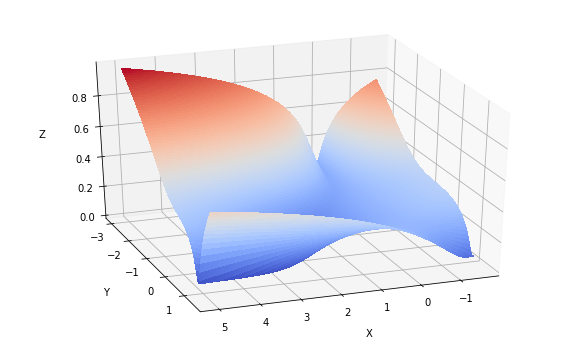

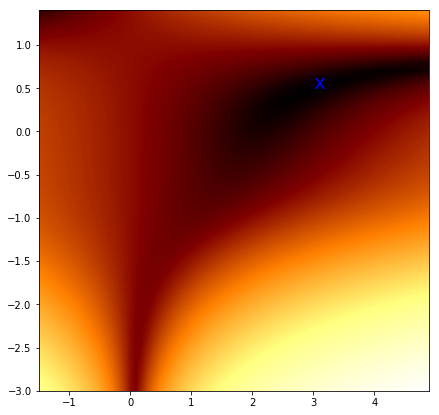

In [3]:
plot_cost_function_3d(cost_f)
plt.show()

plot_contourf(cost_f, figsize=[7,7])
plt.show()

## Optimizers implementation

The next subsections show several implementations of the most used optimizers of the last years, from the simplest one (vanilla Gradient Descent) until one of the state-of-the-art improvements (ADAM).

With the aim of comparing among of their performance, the next figures are generated.
- **The absolute error evolution over each iteration**, understanding the error as the absolute difference between the evaluation of the objective function using the parameters given by the optimization algorithm ($J(\hat{\theta_t})$) and the actual optimum value ($J(\theta_{opt})$) i.e. the absolute distance to the optimum only considering the z-axis: $|J(\hat{\theta_z}) - J(\theta_z)|$.
- **The euclidean distance to the minimum of the objective function**, i.e. the $l_2$ norm.

<div align="center"> $l_2 = || \{\theta_{opt},J(\theta_{opt})\}, \{\hat{\theta_t},J(\hat{\theta_t})\} ||_2$</div>

- **The spatial evolution** consisting of the 3 subsequent figures.
    - The temporal evolution of the $x$ parameter.
    - The temporal evolution of the $y$ parameter.
    - A XY figure showing the path to the minimum suggested by the algorithm.
- **The dynamic evolution** consisting of the 3 subsequent figures.
    - The module of the velocity in the $x$ axis ($|\vec{v_x}|$) over time.
    - The module of the velocity in the $y$ axis ($|\vec{v_y}|$) over time.
    - The module of the velocity of the compounded x and y axes over time ($|\vec{v}|$).

### Gradient Descent

Vanilla Gradient Descent (GD) is the simplest algorithm that is going to be analysed in this document. It consists of recursively taking steps proportional to the negative gradient. Given a set of parameters ($\theta_t$), the parameters update ($\theta_{t+1}$) can be computed as shown in the next expression.


<br/><div align="center">$\theta_{t+1} = \theta_t − \eta \cdot \nabla_\theta \cdot J(\theta_t)$</div>


> where $J(\theta_t)$ is the objective function to be minimized, $\eta$ is the learning rate, and $\nabla_\theta$ is the gradient with respect to the parameters of the objective function.

The value of the learning rate ($\eta$) should be adjusted manually. Its optimum value depends on the objective function. In a neural network which takes standarized data as input, a good rule of thumb is to start with $\eta = 10^{-3}$ and vary it logarithmically to choose the one which works better. If the $\eta$ parameter is too small, the algorithm will converge very slowly. If on the other hand it is too big, the system will became unstable (i.e. it will not converge).

#### Implementation

In [4]:
class SGD(Optimizer):
    def __init__(self, cost_f, lr=0.001, x=None, y=None):
        super().__init__(cost_f, lr, x, y)
            
    def step(self, lr = None):
        if not lr:
            lr = self.lr
        f = cost_f.eval(self.x, self.y)
        dx = cost_f.df_dx(self.x, self.y)
        dy = cost_f.df_dy(self.x, self.y)
        self.x = self.x - lr*dx
        self.y = self.y - lr*dy
        return [self.x, self.y]

#### Application over the objective function

In [5]:
opt = SGD(cost_f=cost_f, lr=learning_rate)

In [6]:
errors_sgd, distance_sgd,\
xs_sgd, ys_sgd = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

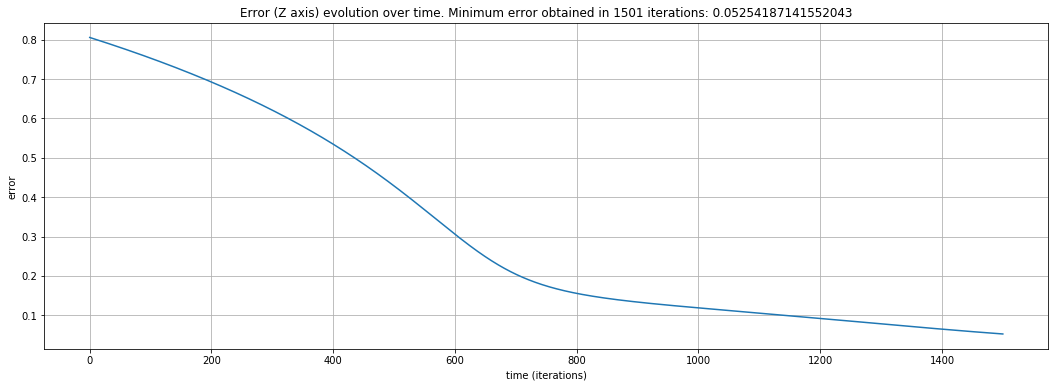

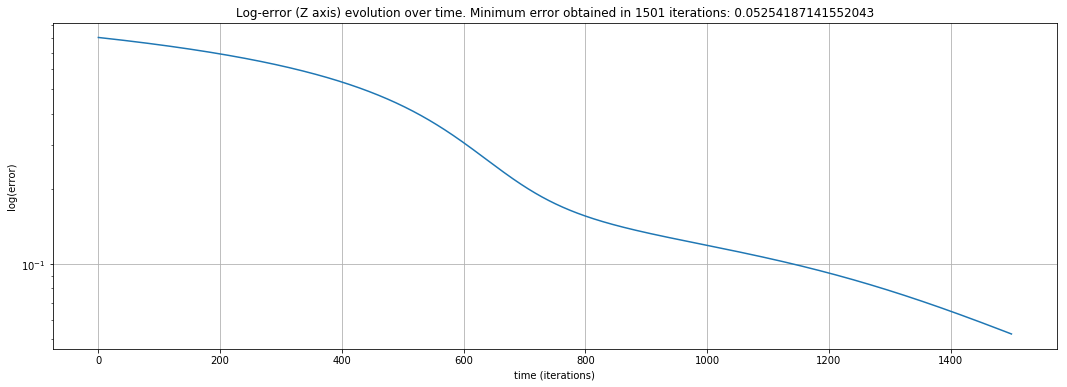

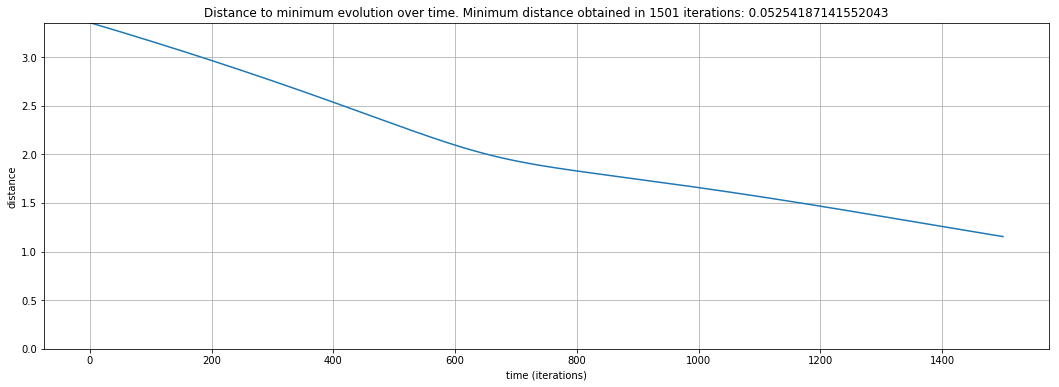

In [7]:
plot_evolution_charts(cost_f, errors_sgd, distance_sgd, xs_sgd, ys_sgd)

#### Cinematics

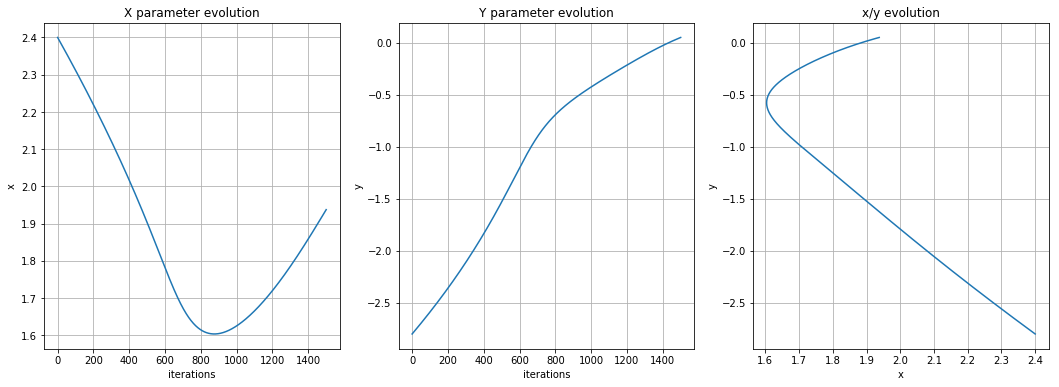

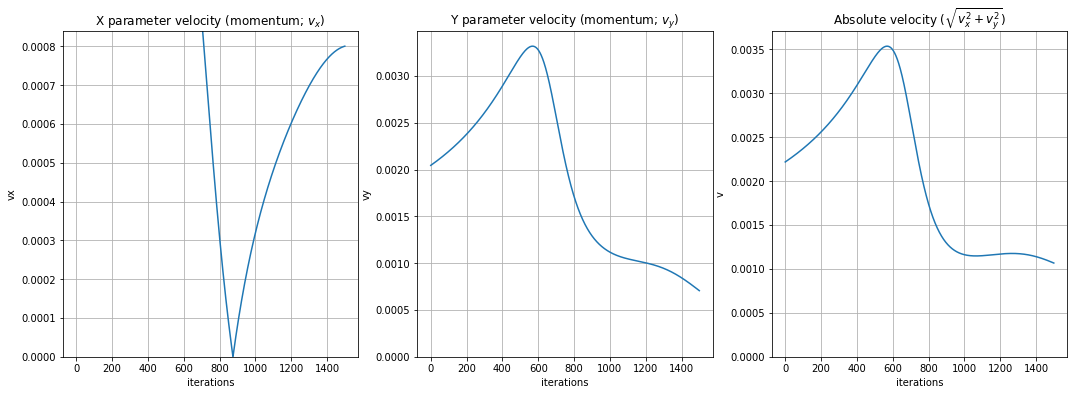

In [8]:
plot_cinematics_charts(xs_sgd, ys_sgd)

#### Conclusion

Looking at the first figure, one can think that this algorithm converges very fast but it is not true: take a look at the semi-logarithmic scale plot (the second one). 

The spatial evolution shows the secret. The algorithm follows the negative gradient direction, which for the first steps is very strong due to the slope of the space. After that, it continues following the negative gradient but now the gradient signal is lighter (i.e. the space is much less inclined). Because of this algorithm follows the negative gradient direction with a step proportional to its magnitude, it presents a very slow convergence when it is small slopes.

Regarding the dynamic evolution, it clearly shows that this algorithm's velocity depends directly on the magnitude of the gradient. If the gradient is small, the algorithm advances really slowly; this is the problem that arises with this objective function (in which there are slopes of different orders of magnitude). That is the reason why the absolute velocity decays fast to a very small value after 900 iterations. The XY plot shows the trajectory followed by the algorithm. 

### Gradient Descent with Momentum

The first improvement over vanilla Gradient Descent is the addition of a momentum. It can be thought as the potential and cynetic energy of a ball falling down over a constant slope. This ball has a velcity of 0 with time $t_0$ and it increases over time. It keeps improving until the potential energy is cancelled by the friction. At this point, it remains constant. 

The formulation of this modification is shown below. The parameter $\gamma$ is introduced and it is known as the momentum term. It is essential that $\gamma < 1$ to simulate the friction behavior. If this condition is not met, the system becomes unstable. A typical value for the momentum term is $\gamma = 0.9$.

<br/><div align="center">$v_t = \gamma \cdot v_{t-1} − \eta \cdot \nabla_\theta \cdot J(\theta_t)$</div>

<div align="center">$\theta_{t+1} = \theta_{t} - v_t$</div>

#### Implementation

In [9]:
class SGD_momentum(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, beta=beta)
        self.vx = 0
        self.vy = 0
        
    def step(self, lr = None, beta=None):
        if type(lr) == type(None):
            lr = self.lr
        if type(beta) == type(None):
            beta = self.beta
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.vx = beta * self.vx + lr * dx
        self.vy = beta * self.vy + lr * dy
        self.x += - self.vx
        self.y += - self.vy
            
        return [self.x, self.y]

#### Application over the objective function

In [10]:
opt = SGD_momentum(cost_f=cost_f, lr=learning_rate, beta=0.9)

In [11]:
errors_momentum, distance_momentum,\
xs_momentum, ys_momentum = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

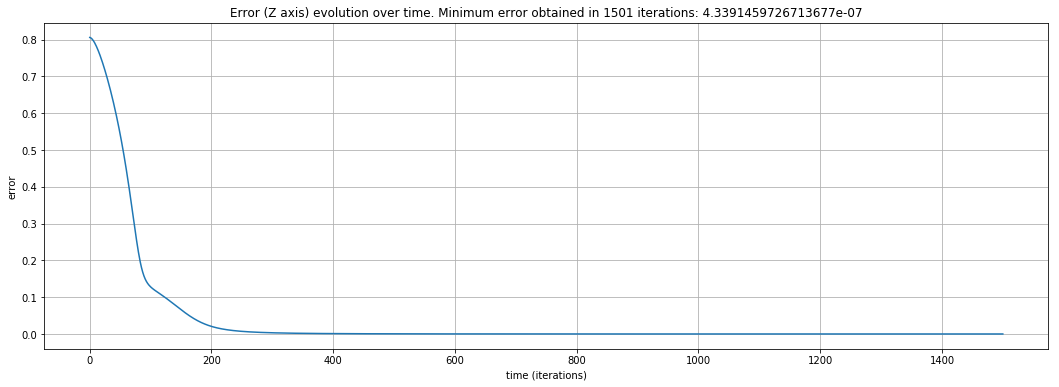

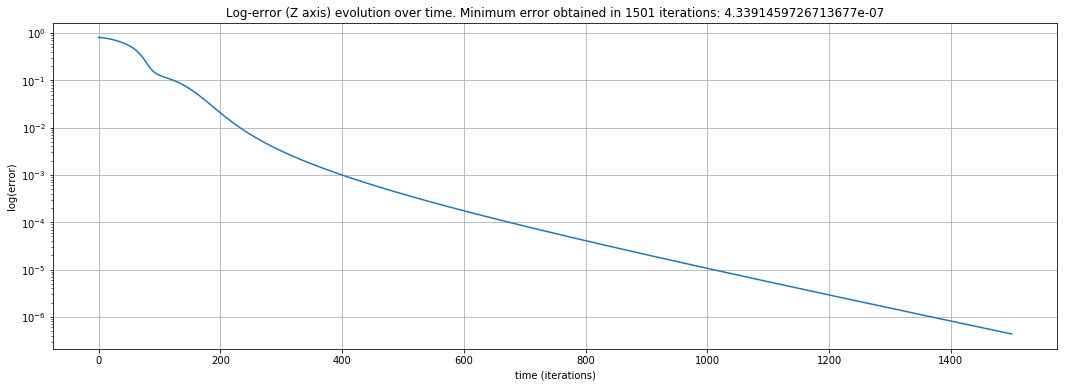

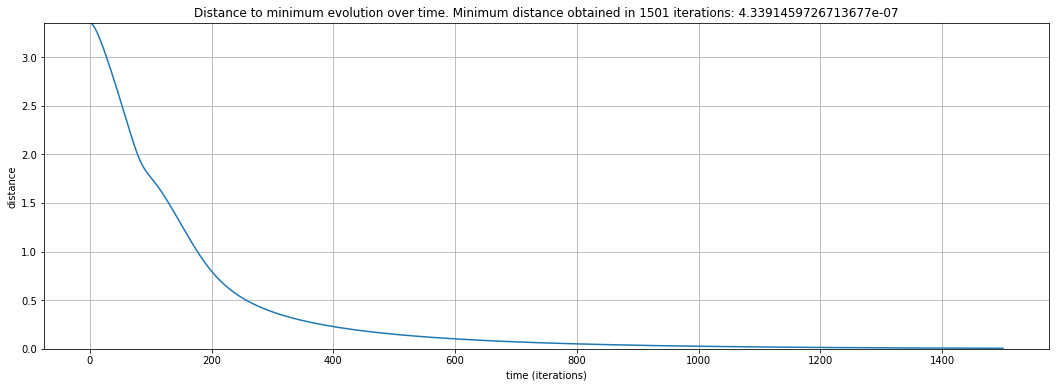

In [12]:
plot_evolution_charts(cost_f, errors_momentum, distance_momentum, xs_momentum, ys_momentum)

#### Cinematics

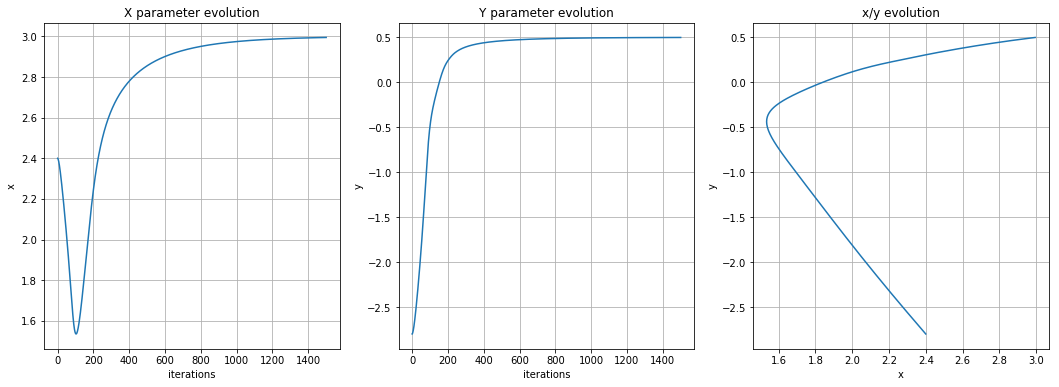

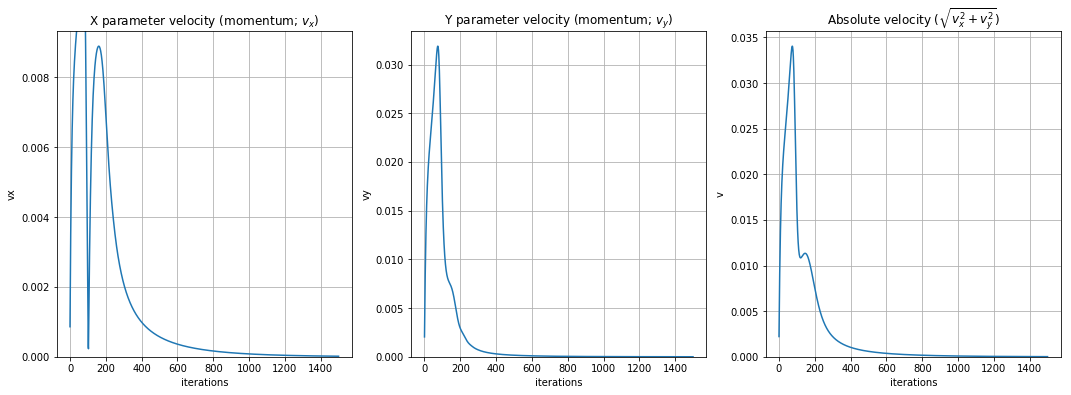

In [13]:
plot_cinematics_charts(xs_momentum, ys_momentum)

#### Conclusion

As shown in the first 3 figures, this approach outperforms the vanilla version. The momentum addition makes the algorithm converge faster due to the cumulative momentum when the slope is slow; it produces a momentum accumulation in this direction, which helps the algorithm arrive faster to the global minimum. However, sometimes a damped oscillation appears, which can hurt performance. This is due to the momentum again: the momentum addition implies inertia. Think of a marble rolling down the ravine from one of its walls.

It turns into a very interesting exercise to increase/decrease the momentum term $\gamma$ to see how the system behaves. 

### Gradient Descent with Nesterov Momentum

Gradient Descent with Nesterov Momentum is a simple modification over the Gradient descent with momentum algorithm. It tries to correct the oscilations produced by the inertia of the momentum by simply, instead of summing the momentum vector to the negative gradient vector, computing the gradient from the point where the momentum vector ends so that its trajectory is totally or partially corrected. 

It is easier to understand it with drawings. Figure 1 shows a typical momentum algorithm, while figure 2 shows the Nesterov approach. As it can be noticed in the figures, the difference between them is that the momentum algorithm calculates the gradient from the last point and sums it to the moment, and the Nesterov modification calculates the gradient from the momentum vector so that if the momentum is too high, it is correcting it in some way.

![sth](img/momentum.png)

<div align="center">Figure 1: normal momentum updates</div>

![sth](img/nesterov.png)
<div align="center">Figure 2: momentum updates with nesterov correction</div>

#### Implementation

In [14]:
class SGD_nesterov_momentum(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, beta=beta)
        self.vx = None
        
    def step(self, lr = None, beta=None):
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        if type(lr) == type(None):
            lr = self.lr
        if type(beta) == type(None):
            beta = self.beta
        if type(self.vx) == type(None) or type(self.vy)==type(None):
            self.vx = lr * dx
            self.vy = lr * dy
        else:
            dx_in_vx = self.cost_f.df_dx(self.x-beta*self.vx, self.y-beta*self.vy)
            dy_in_vy = self.cost_f.df_dy(self.x-beta*self.vx, self.y-beta*self.vy)
            self.vx = beta * self.vx + lr * dx_in_vx
            self.vy = beta * self.vy + lr * dy_in_vy
        self.x += - self.vx
        self.y += - self.vy
            
        return [self.x, self.y]


In [15]:
opt=SGD_nesterov_momentum(cost_f=cost_f, lr=learning_rate, beta=0.9)

In [16]:
errors_nesterov, distance_nesterov,\
xs_nesterov, ys_nesterov = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

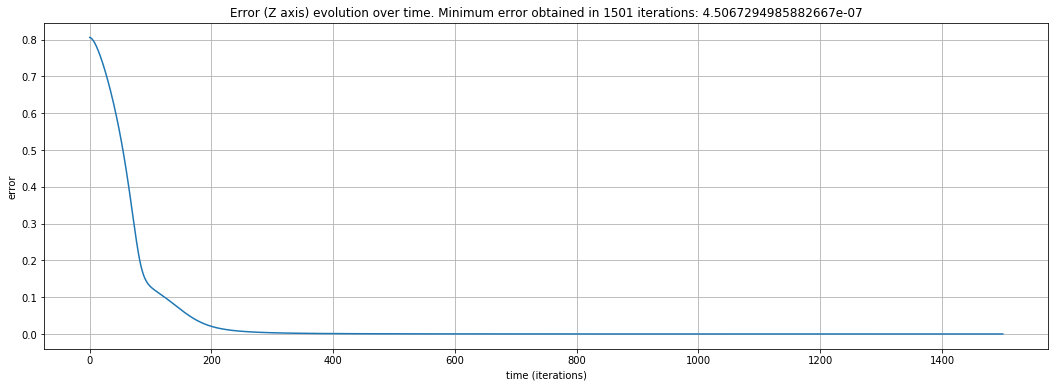

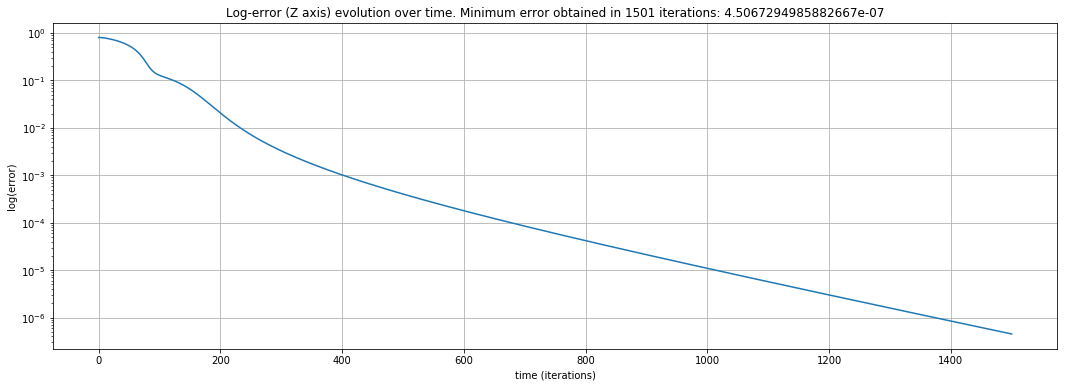

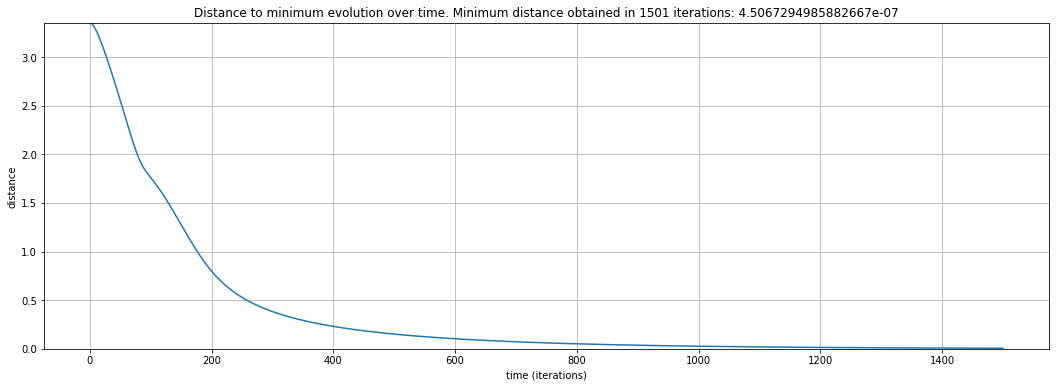

In [17]:
plot_evolution_charts(cost_f, errors_nesterov, distance_nesterov, xs_nesterov, ys_nesterov)


#### Cinematics

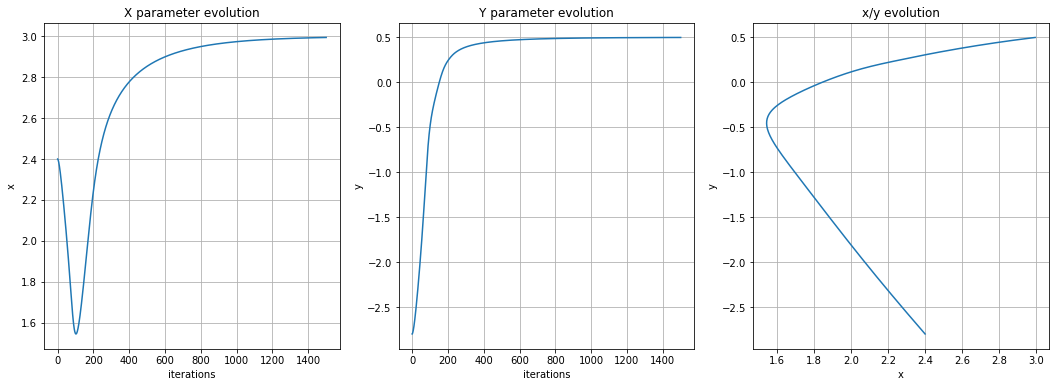

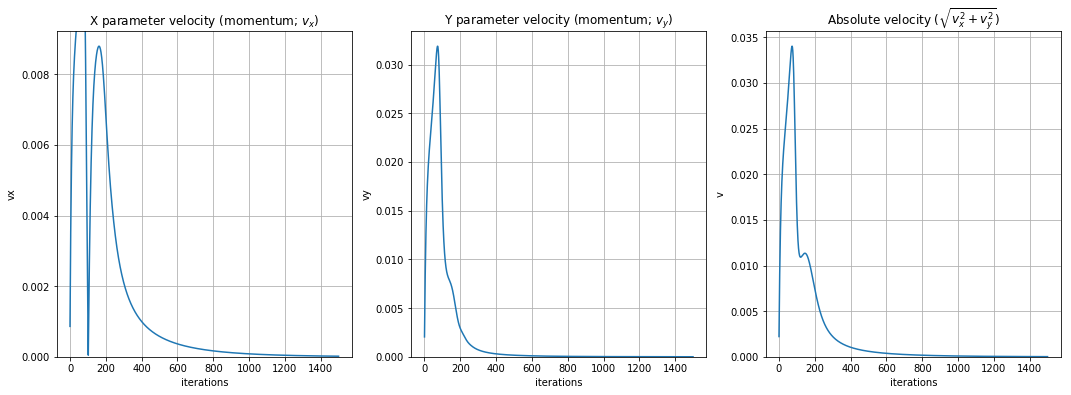

In [18]:
plot_cinematics_charts(xs_nesterov, ys_nesterov)

### Adagrad

AdaGrad (Adaptive Gradient) is a method considered by the author as a _subgradient method_ which attempts to incorporate knowledge of the geometry of the data observed in previous iterations in order to perform informative gradient based learning. Its basic idea is to adapt the learning rates to each parameter so that low frequent occurring features (sparse) have high learning rates and high frequently occurring features (dense) have low learning rates. For this purpose, the algorithm divides each gradient components by the $L_2$ norm of the value of the components of the previous gradients..

$$\mathbf{w_{t+1}} = \mathbf{w_t} - \displaystyle\frac{\eta}{\sqrt{\displaystyle\sum_{T=1}^{t} \mathbf{g_T}^2+\epsilon}} \cdot \mathbf{g}_t$$

Where $\mathbf{g_t}$ represents the gradient of the current iteration, $\eta$ represents the stepsize, $t$ the iteration step and $\epsilon$ the fuze factor which usually has a value of $10^-8$.

In [19]:
class AdaGrad(Optimizer):
    def __init__(self, cost_f, lr=0.001, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y)
        self.sumsq_dx = 0
        self.sumsq_dy = 0
        
    def step(self, lr = None):
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        self.sumsq_dx += dx**2
        self.sumsq_dy += dy**2
        self.x = self.x - (lr/(np.sqrt(epsilon + self.sumsq_dx)))*dx
        self.y = self.y - (lr/(np.sqrt(epsilon + self.sumsq_dy)))*dy
        
        return [self.x, self.y]
        

In [20]:
opt=AdaGrad(cost_f=cost_f, lr=learning_rate)

In [21]:
errors_adagrad, distance_adagrad,\
xs_adagrad, ys_adagrad = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

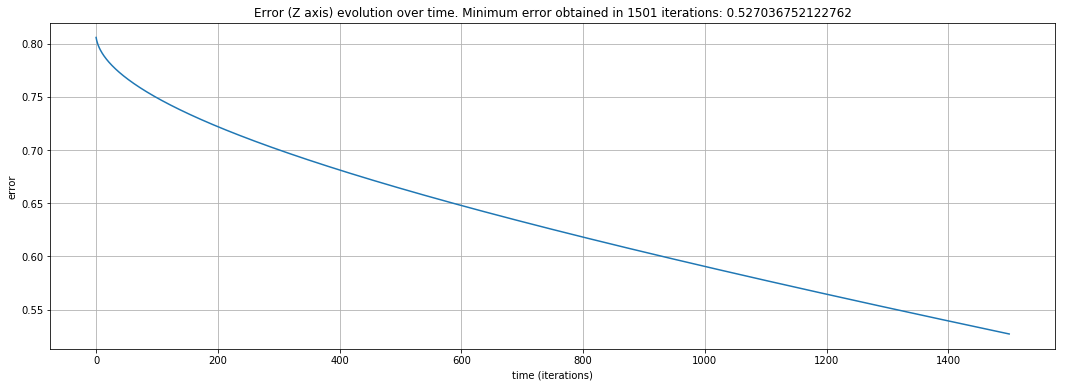

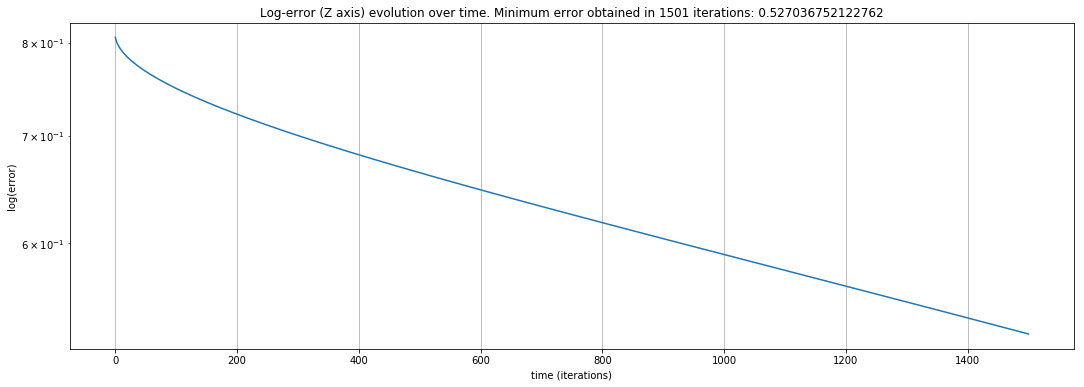

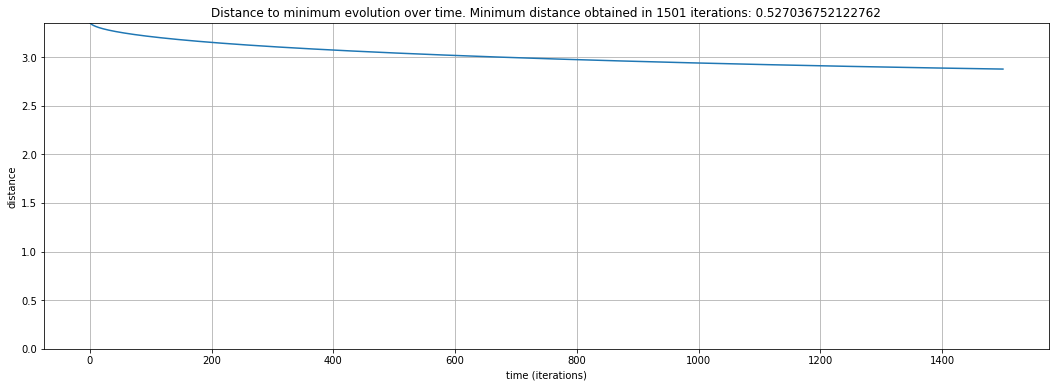

In [22]:
plot_evolution_charts(cost_f, errors_adagrad, distance_adagrad, xs_adagrad, ys_adagrad)


#### Cinematics

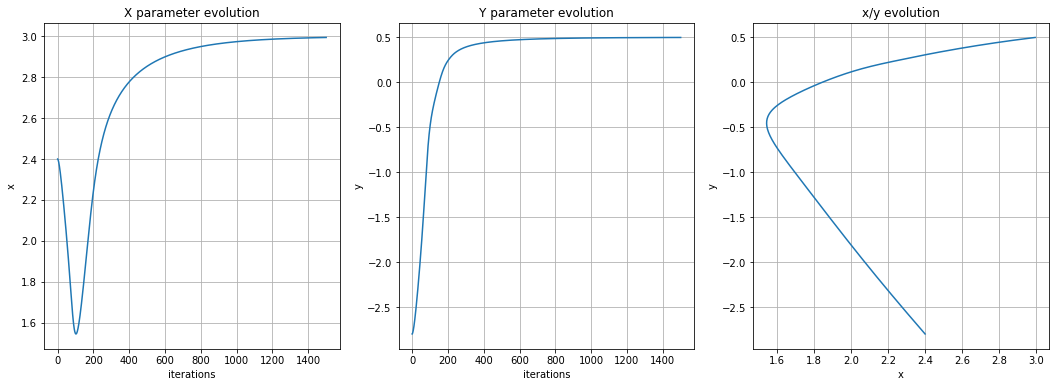

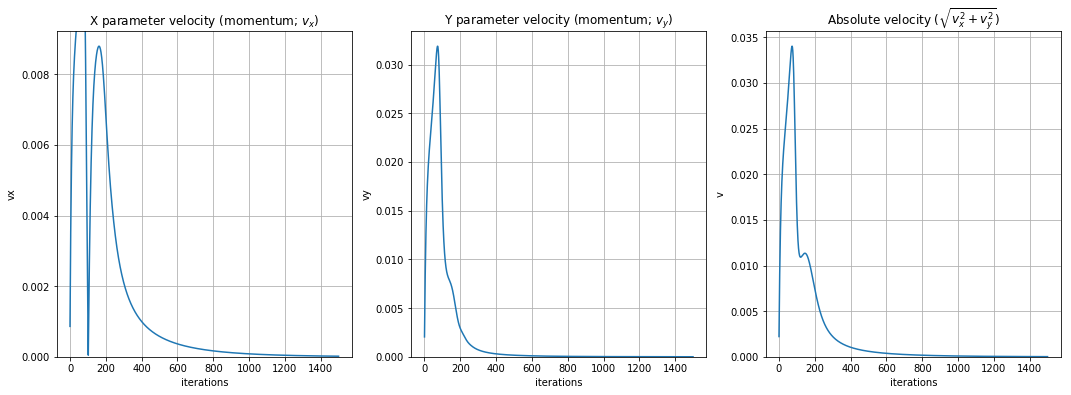

In [23]:
plot_cinematics_charts(xs_nesterov, ys_nesterov)

#### Conclusion 

The idea behind this method is quite interesting, but there is an issue which commonly appears when running it: the norm vector grows too much eventually and the training slows to a halt, preventing the algorithm to reach the local minimum. This effect can be easily seen in the charts above.

### RMSprop

This algorithm is an attempt to adjust easily the AdaGrad algorithm in order to reduce its aggresive decreasing learning rate. Instead of calculating the $L_2$ norm of the gradients, it uses a weighted moving average of the squared gradients. As a curiosity, this algorithms has never been published; instead, it was designed by *Geoffrey Hinton* in [one of the slides](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) of the **Neural Networks for Machine Learning** Coursera course.

$$\mathbf{m_t} = 0.9 \cdot \mathbf{m_{t-1}} + 0.1\cdot \mathbf{g_t}^2$$

$$\mathbf{\Delta x} = \frac{1}{\sqrt{\mathbf{m_t}+\epsilon}}\cdot \mathbf{g_t}$$

$$\mathbf{w_{t+1}} = \mathbf{w_t} - \eta  \cdot \Delta x$$

In [24]:
class RMSProp(Optimizer):
    def __init__(self, cost_f, lr=0.001, decay_rate=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, decay_rate=decay_rate)
        self.ms_x = 0
        self.ms_y = 0
        
    def step(self, lr=None, decay_rate=None):
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        if not decay_rate:
            decay_rate = self.decay_rate
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        self.ms_x = self.decay_rate * (self.ms_x) + (1-self.decay_rate)*dx**2
        self.ms_y = self.decay_rate * (self.ms_y) + (1-self.decay_rate)*dy**2
        self.x = self.x - (lr/(epsilon + np.sqrt(self.ms_x)))*dx
        self.y = self.y - (lr/(epsilon + np.sqrt(self.ms_y)))*dy
        
        return [self.x, self.y]
        

#### Application over the objective function

In [25]:
opt = RMSProp(cost_f=cost_f, lr=learning_rate)

In [26]:
errors_rmsprop, distance_rmsprop,\
xs_rmsprop, ys_rmsprop = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

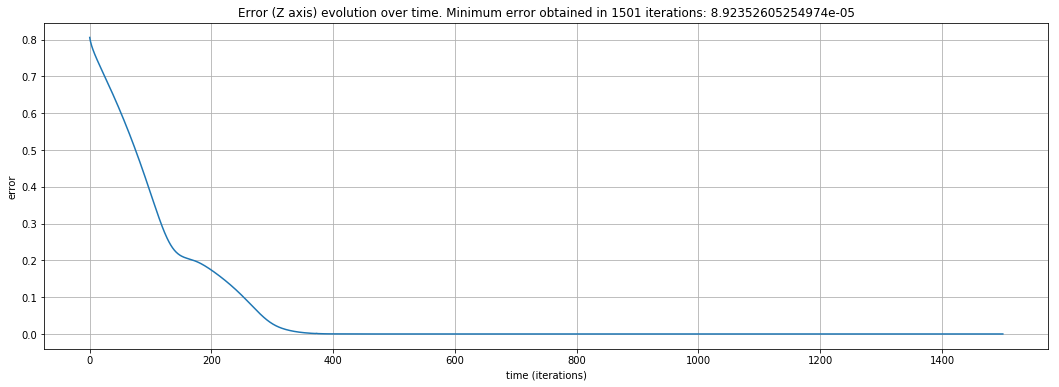

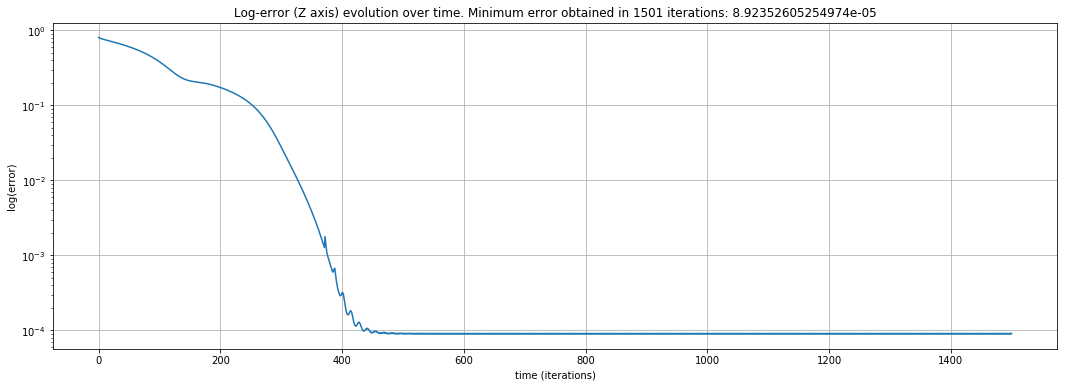

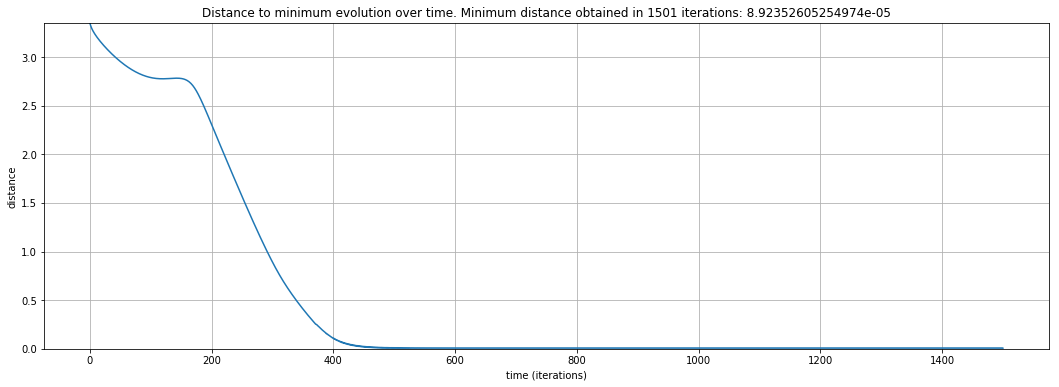

In [27]:
plot_evolution_charts(cost_f, errors_rmsprop, distance_rmsprop, xs_rmsprop, ys_rmsprop)

#### Cinematics

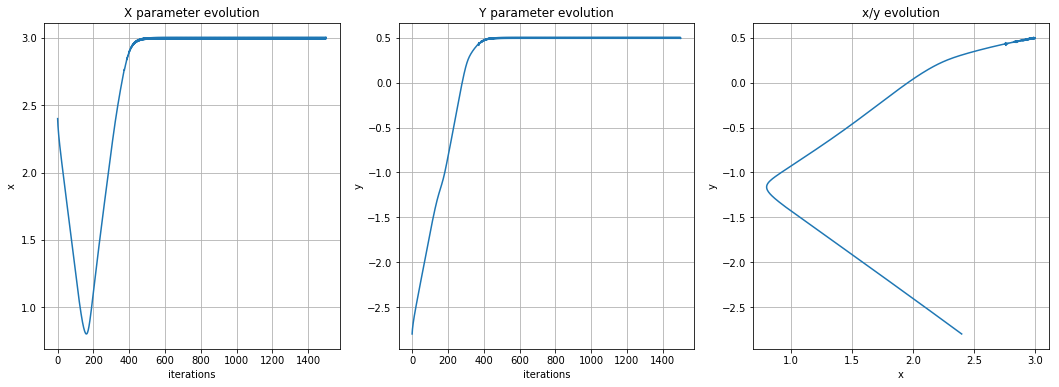

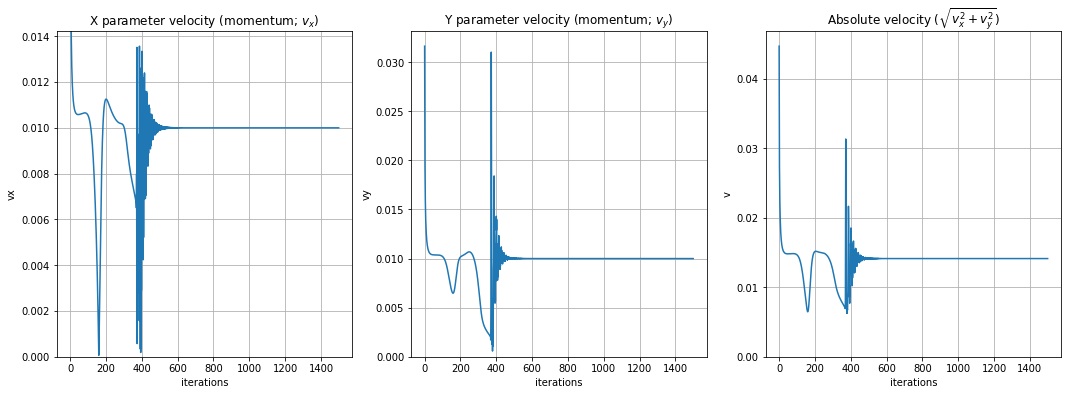

In [28]:
plot_cinematics_charts(xs_rmsprop, ys_rmsprop)

### AdaDelta

This algorithm was another attempt to fix AdaGrad issues with the coarse adjustment of the learning rate. It implements a method for adapting the learning rate per-dimension so that it doesn't have to be manually tuned. The method is fairly similar to the RMSProp algorithm, the only difference lays in the calculation of $\Delta w$, in which it appears the term RMS value of $s_{t-1}$ for unit consistency

$$\mathbf{m_t} = 0.9 \cdot \mathbf{m_{t-1}} + 0.1\cdot \mathbf{g_t}^2$$

$$ \Delta w = \frac{\sqrt{\mathbf{s_{t-1}}+\epsilon}}{\sqrt{\mathbf{m_t}+\epsilon}}\cdot \mathbf{g_t}$$

$$\mathbf{w_{t+1}} = \mathbf{w_t} - \eta \cdot \Delta x$$

$$\mathbf{s_t} = 0.9 \cdot \mathbf{s_{t-1}} + 0.1\cdot \Delta w^2$$

In [29]:
class AdaDelta(Optimizer):
    def __init__(self, cost_f, lr=0.001, decay_rate=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, decay_rate=decay_rate)
        self.decay_x = 0
        self.decay_y = 0
        self.decay_dx = 1
        self.decay_dy = 1
        
    def step(self, lr=None, decay_rate=None):
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        if not decay_rate:
            decay_rate = self.decay_rate
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        # Update decays
        self.decay_x = decay_rate * (self.decay_x) + (1-decay_rate)*dx**2
        self.decay_y = decay_rate * (self.decay_y) + (1-decay_rate)*dy**2
        
        update_x = dx*((np.sqrt(epsilon + self.decay_dx))/(np.sqrt(epsilon + self.decay_x)))
        update_y = dy*((np.sqrt(epsilon + self.decay_dy))/(np.sqrt(epsilon + self.decay_y)))
        
        self.x = self.x - (update_x)*lr
        self.y = self.y - (update_y)*lr
        
        # Update decays d
        self.decay_dx = decay_rate * (self.decay_dx) + (1-decay_rate)*update_x**2
        self.decay_dy = decay_rate * (self.decay_dy) + (1-decay_rate)*update_y**2
        
        return [self.x, self.y]

#### Application over the objective function

In [30]:
learning_rate=0.01

In [31]:
opt = AdaDelta(cost_f=cost_f, lr=learning_rate)

In [32]:
errors_adadelta, distance_adadelta,\
xs_adadelta, ys_adadelta = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

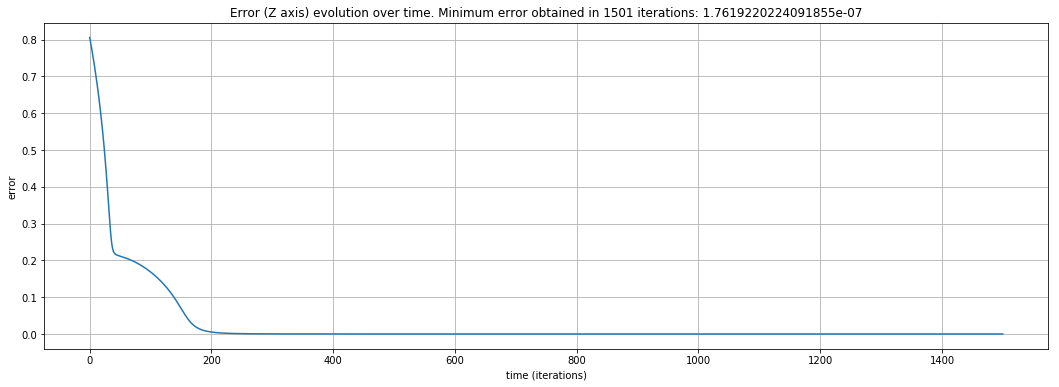

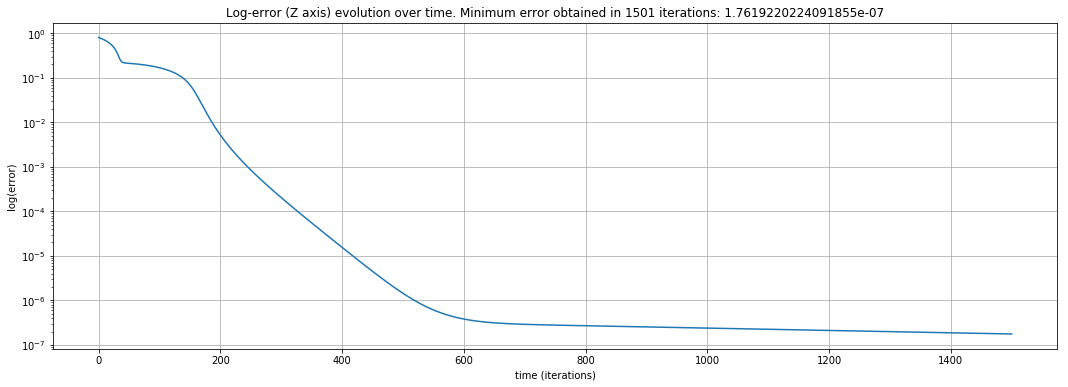

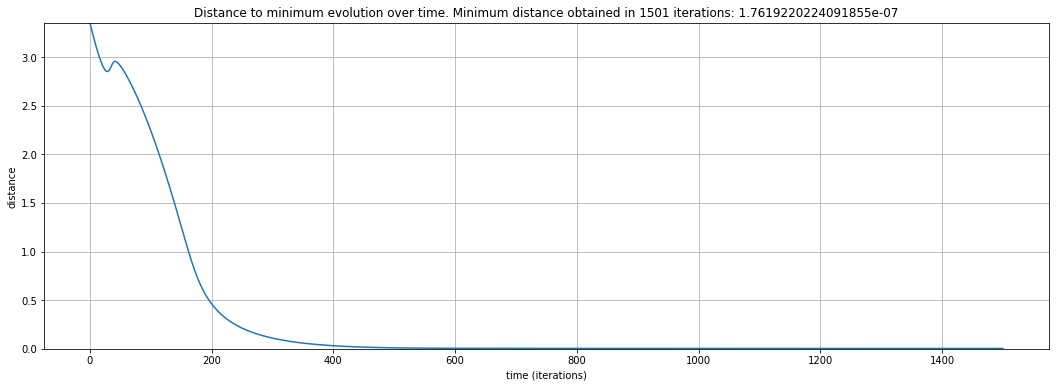

In [33]:
plot_evolution_charts(cost_f, errors_adadelta, distance_adadelta, xs_adadelta, ys_adadelta)

#### Cinematics

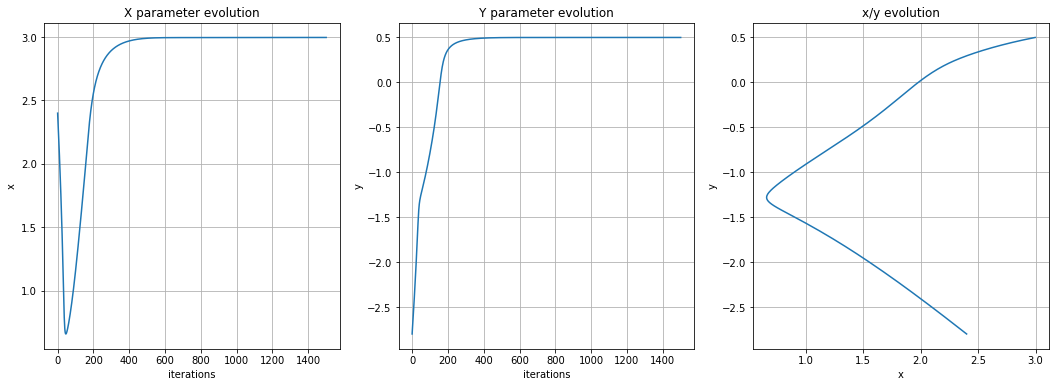

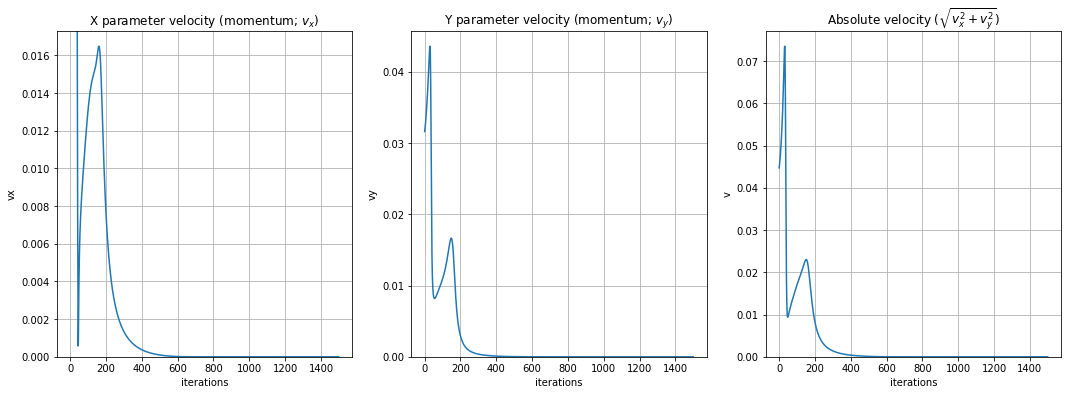

In [34]:
plot_cinematics_charts(xs_adadelta, ys_adadelta)

### ADAM

Adam (Adaptative Moment estimation) is a first order optimization algorithm based on adaptative estimates of the first and second moments which tipically requires zero (or little) tuning. 

This method is designed as a combination of 2 popular methods: Adagrad (works well with sparse gradients) and RMSProp (works well with non-stationary settings). It has been proved that it is able to successfully optimize very stochastic functions. The stochasticity of the objective functions usually might come from its evaluation at small random subsamples of data (minibatches). 

The following equations describe in a clear way the nitty gritty of Adam. Let $f(\theta)$ be the objective function to be minimized ($arg min_{\theta}(f)$). Let $\mathbf{g}$ be the gradient of the stochastic objective function; $\mathbf{g_t} = \mathbf{\nabla f_t(\theta)}$ represent the gradient at timestep $t$. 

The first moment $\mathbf{m_t}$ is calculated as the moving average of the gradient and represents its mean. The first moment is weighted by the $\beta_1$.

$$\mathbf{m_t} := \beta_1 \cdot \mathbf{m_{t-1}} + (1-\beta_1) \cdot \mathbf{g_t} $$

The second moment $\mathbf{v_t}$ is calculated as the squared moving average of the gradient and represents its uncentered variance. The second moment is weighted by the $\beta_2$
$$\mathbf{v_t} := \beta_2 \cdot \mathbf{v_{t-1}} + (1-\beta_2) \cdot \mathbf{g_t}^2$$

Until this point, both moments have a bias due to they are initialized as 0 ($\mathbf{m_t} = 0$; $\mathbf{v_t} = 0$), that means that the moments calculated at the begining of the process will have a lot of weight because there is no _past information_ about the momentum. With the aim of solving this effect, the moments that will be used to update the parameters are corrected as it is shown below. $\hat{\mathbf{m_t}}$ and $\hat{\mathbf{v_t}}$ represent the corrected versions of $\mathbf{m_t}$ and $\mathbf{v_t}$ respectively.
$$\hat{\mathbf{m_t}} := \mathbf{m_t} \cdot \displaystyle\frac{1}{1-\beta_1^t}$$

$$\hat{\mathbf{v_t}} := \mathbf{v_t} \cdot \displaystyle\frac{1}{1-\beta_2^t}$$


Finally, the parameters of the objective function are updated as indicated in the following equation. 
$$\mathbf{\theta_t} := \mathbf{\theta_{t-1}} - \alpha \cdot \displaystyle\frac{\hat{\mathbf{m_t}}}{\sqrt{\hat{\mathbf{v_t}}}+ \epsilon}$$

This equation can be rewritten as follows; it is a more efficient way of computing adam. Although it lacks a bit of clarity, it is easier to identify each of the components of the method. 
$$\mathbf{\theta_t} := \mathbf{\theta_{t-1}} - \alpha \cdot \displaystyle\frac{\sqrt{1-\beta_2^t}}{1-\beta_1^t} \cdot \displaystyle\frac{\mathbf{m_{t}}}{\sqrt{\mathbf{v_{t}}} + \epsilon}$$

Let's decompose it.

- $\mathbf{\theta_{t-1}}$ is the previous parameters vector to be updated.
- $\alpha$ is the stepsize, usually 0.001.
- $\displaystyle\frac{\sqrt{1-\beta_2^t}}{1-\beta_1^t}$ is the bias correction, which varies over the timesteps of the learning process ($t$). The figure 1 shows how this correction is applied over time; it starts with a low value in the first steps and it grows until it asymptotically arrives to the value of 1 (which means that it takes no effect after several steps). Analytically, one can easily check that the numerator and the denominator are cancelling the effect of the 0-initialization, but it is more easily derivable by checking it in the equations of $\hat{\mathbf{m_t}}$ and $\hat{\mathbf{v_t}}$ and its effect, iteration by iteration, over the parameters $\beta_1$ and $\beta_2$ in the $\mathbf{m_t}$ and $\mathbf{v_t}$ equations.
- Finally, $\displaystyle\frac{\mathbf{m_{t}}}{\sqrt{\mathbf{v_{t}}} + \epsilon}$ holds the update direction. It can be seen as a Signal to Noise Ratio (SNR). When the signal is high with respect to the variance, the updates are preformed in a fast way. On the other hand, if the noise (variance) is high with respect to the signal (mean), the update to be performed will be small. This is a very desired property because a high _SNR_ means that there is a high uncertainty about the real direction of the gradient (remember the function to be optimized is stochastic). $epsilon$ is simply a very small term ($10^{-8}$ tipically) that makes this term stable when $\mathbf{v_{t}}$ is zero. 

Takeaways.

- Adam combines Adagrad and RMSprop algorithms holding robustness and speed.
    - Ability to handle very sparse gradients from AdaGrad.
    - Ability to deal with non-stationary objectives from RMSprop. 
- There is no need to perform a stepsize annealing because the first and second moments factor $\left(\displaystyle\frac{\mathbf{m_{t}}}{\sqrt{\mathbf{v_{t}}} + \epsilon}\right)$ does it automatically since the _SNR_ value tipically decreases closer to 0 towards an optimum. 
- $\alpha = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$ by default. It is not usually necessary to change them.
- Adam's $\beta_2$ parameter can be increased when the data is very sparse (for example when working with bag-of-words data).
- AdaGrad is the same as Adam with $\beta_2 \rightarrow 1$, $\beta_1 = 0$ and annealing $\alpha$.
- With convex and non-sparse objectives, SGD with Nesterov momentum performance is similar to Adam. Though in SGD the learning rate has to be manually picked.

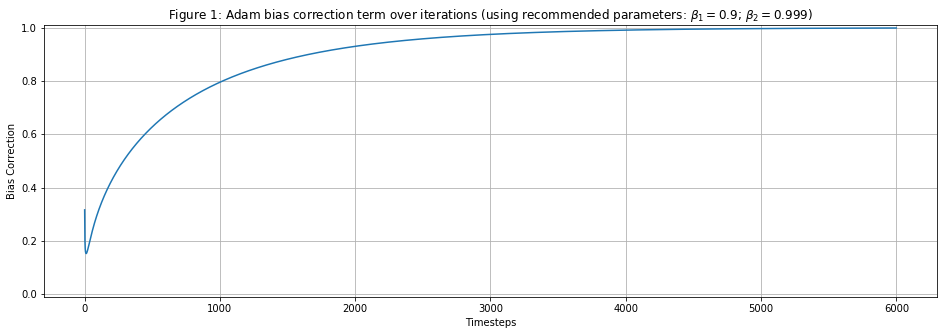

In [35]:
b1 = 0.9; b2 = 0.999; t = np.arange(1,6000)
bias_correction = np.sqrt(1-b2**t)/(1-b1**t)
plt.figure(figsize=[16, 5]); plt.grid(); plt.plot(t, bias_correction); plt.ylim([0-0.01,1.01]); 
plt.title("Figure 1: Adam bias correction term over iterations (using recommended parameters: $\\beta_1 = 0.9$; $\\beta_2 = 0.999$)")
plt.grid(which="major")
plt.xlabel("Timesteps"); plt.ylabel("Bias Correction"); 
plt.grid()
plt.show()

In [36]:
class Adam(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta_1=0.9, beta_2=0.999, x=None, y=None):
        super().__init__(cost_f, lr, x, y, beta_1=beta_1, beta_2=beta_2)
        self.m_x, self.m_y, self.v_x, self.v_y, self.t  = 0, 0, 0, 0, 0
        
    def step(self, lr = None):
        self.t += 1
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.m_x = self.beta_1*self.m_x + (1-self.beta_1)*dx
        self.m_y = self.beta_1*self.m_y + (1-self.beta_1)*dy
        self.v_x = self.beta_2*self.v_x + (1-self.beta_2)*(dx**2)
        self.v_y = self.beta_2*self.v_y + (1-self.beta_2)*(dy**2)
        
        m_x_hat = self.m_x/(1-self.beta_1**self.t)
        m_y_hat = self.m_y/(1-self.beta_1**self.t)
        v_x_hat = self.v_x/(1-self.beta_2**self.t)
        v_y_hat = self.v_y/(1-self.beta_2**self.t)

        self.x = self.x - (lr*m_x_hat)/(np.sqrt(v_x_hat)+epsilon)
        self.y = self.y - (lr*m_y_hat)/(np.sqrt(v_y_hat)+epsilon)
        return [self.x, self.y]
        

#### Application over the objective function

In [37]:
opt = Adam(cost_f=cost_f, lr=learning_rate)

In [38]:
errors_adam, distance_adam,\
xs_adam, ys_adam = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

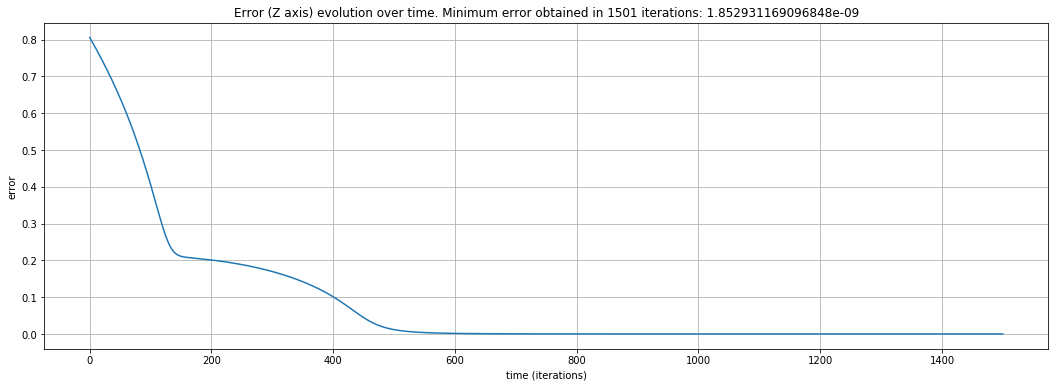

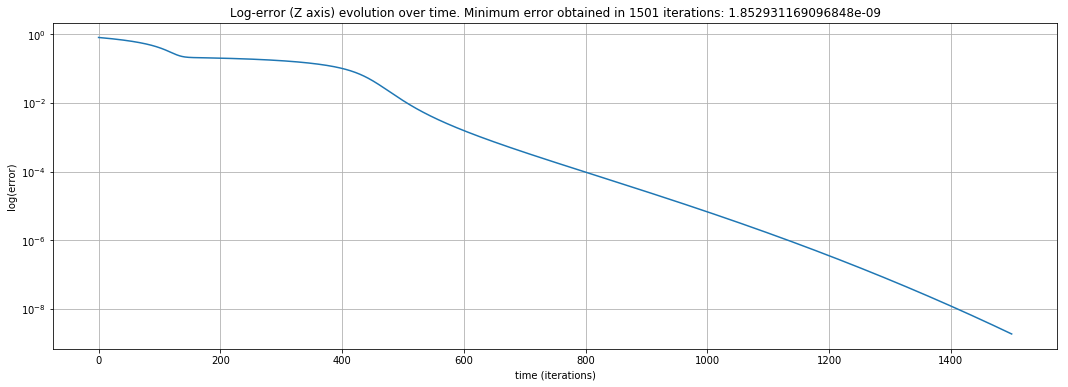

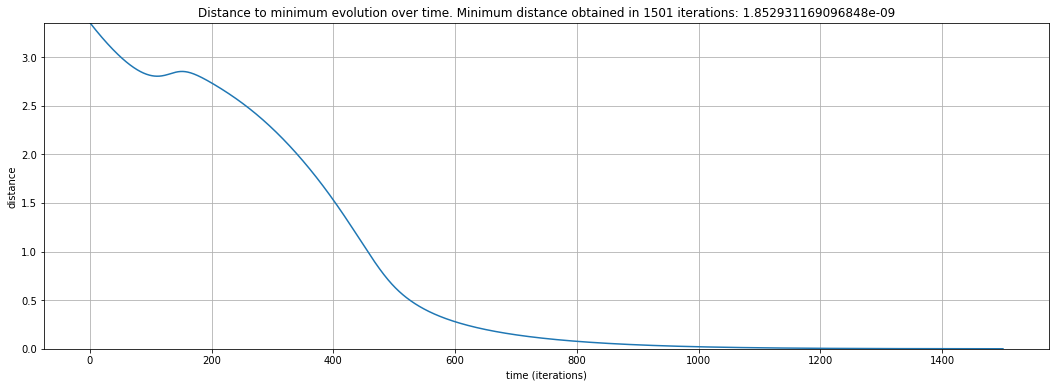

In [39]:
plot_evolution_charts(cost_f, errors_adam, distance_adam, xs_adam, ys_adam)

#### Cinematics

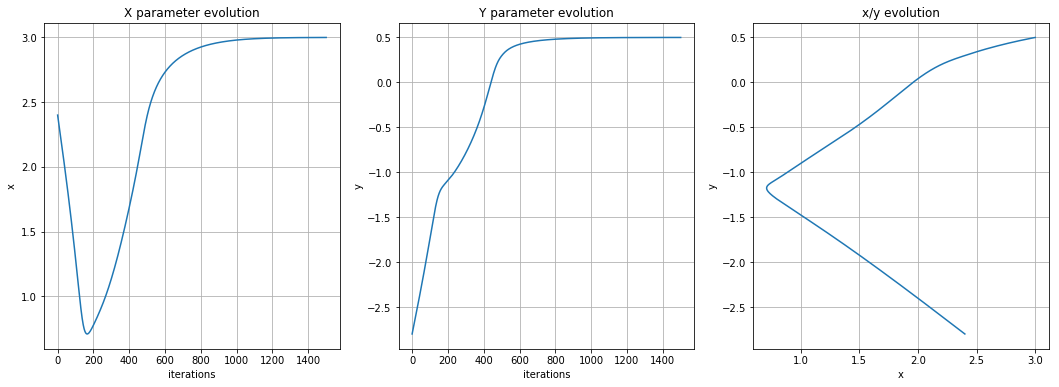

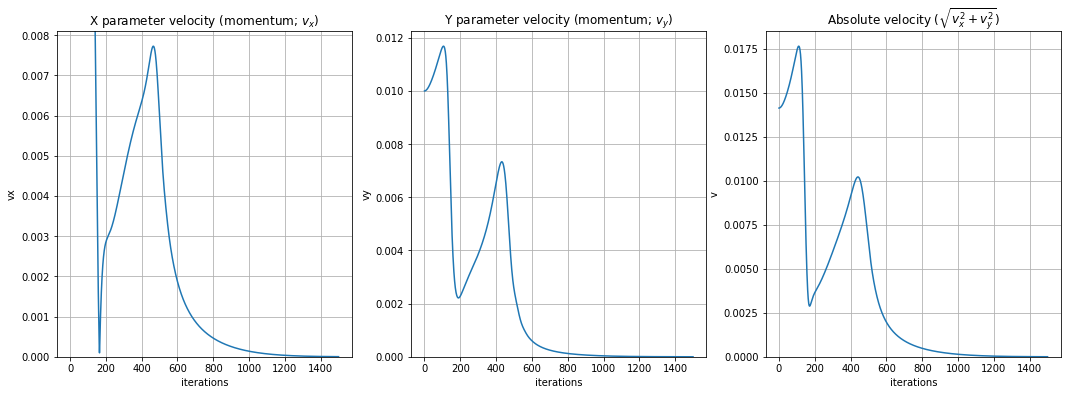

In [40]:
plot_cinematics_charts(xs_adam, ys_adam)

## AdaMax

AdaMax consists of a simple modification of the original Adam algorithm that uses the infinite norm ($L_\infty$) instead of the 2-norm ($L_2$). By using this norm, we can get rid of the $\mathbf{\hat{v_t}}$ adjustment. This modification is porposed by the same authors as Adam, and in the same paper. It consists of the following updates.

$$\mathbf{v_t} := \max(\beta_2 \cdot \mathbf{v_{t-1}}, |\mathbf{g_t}|)$$
$$\mathbf{\theta_t} := \mathbf{\theta_{t-1}} - \alpha \cdot \displaystyle\frac{\hat{\mathbf{m_t}}}{\mathbf{v_t}+ \epsilon}$$

This version is more efficient than Adam because it needs less calculations, and it leads to a similar performing algorithm.


In [41]:
class AdaMax(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta_1=0.9, beta_2=0.999, x=None, y=None):
        super().__init__(cost_f, lr, x, y, beta_1=beta_1, beta_2=beta_2)
        self.m_x, self.m_y, self.v_x, self.v_y, self.t  = 0, 0, 0, 0, 0
        
    def step(self, lr = None):
        self.t += 1
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.m_x = self.beta_1*self.m_x + (1-self.beta_1)*dx
        self.m_y = self.beta_1*self.m_y + (1-self.beta_1)*dy
        self.v_x = max(self.beta_2*self.v_x, abs(dx))
        self.v_y = max(self.beta_2*self.v_y, abs(dy))
        
        m_x_hat = self.m_x/(1-self.beta_1**self.t)
        m_y_hat = self.m_y/(1-self.beta_1**self.t)

        self.x = self.x - (lr*m_x_hat)/(self.v_x+epsilon)
        self.y = self.y - (lr*m_y_hat)/(self.v_y+epsilon)
        return [self.x, self.y]

In [42]:
opt = AdaMax(cost_f=cost_f, lr=learning_rate)

In [43]:
errors_adamax, distance_adamax,\
xs_adamax, ys_adamax = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

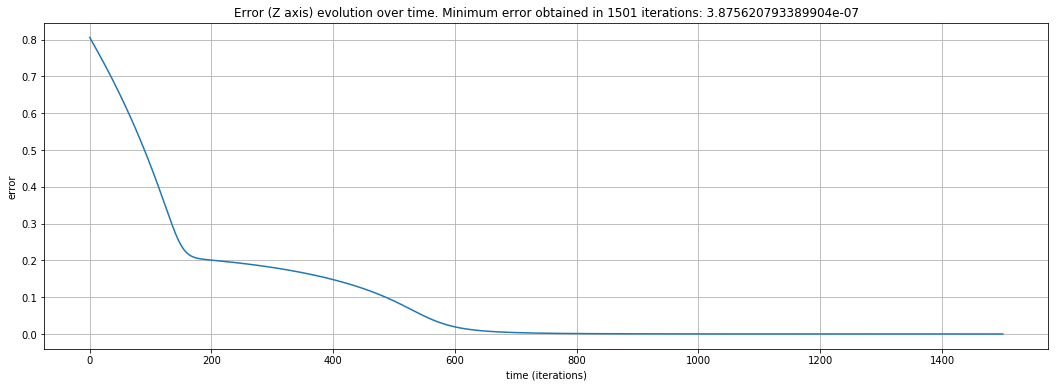

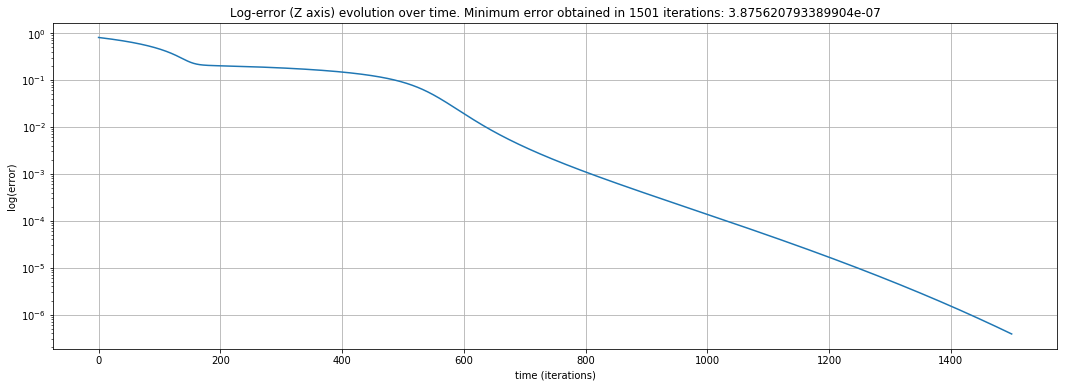

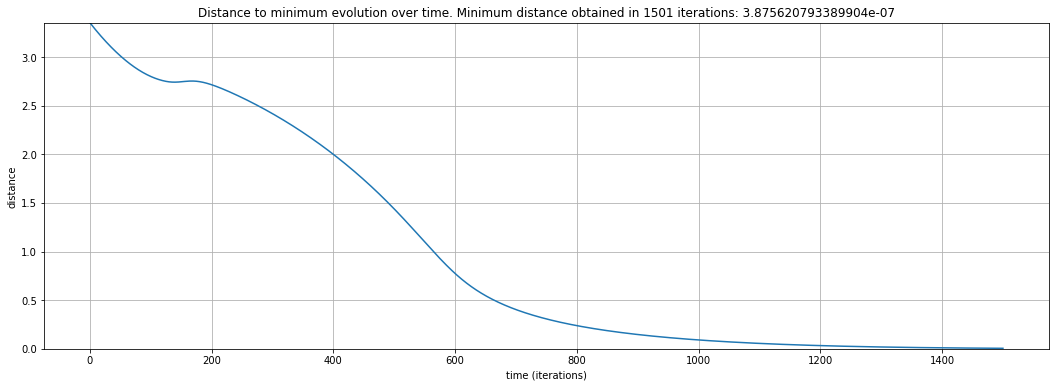

In [44]:
plot_evolution_charts(cost_f, errors_adamax, distance_adamax, xs_adamax, ys_adamax)

#### Cinematics

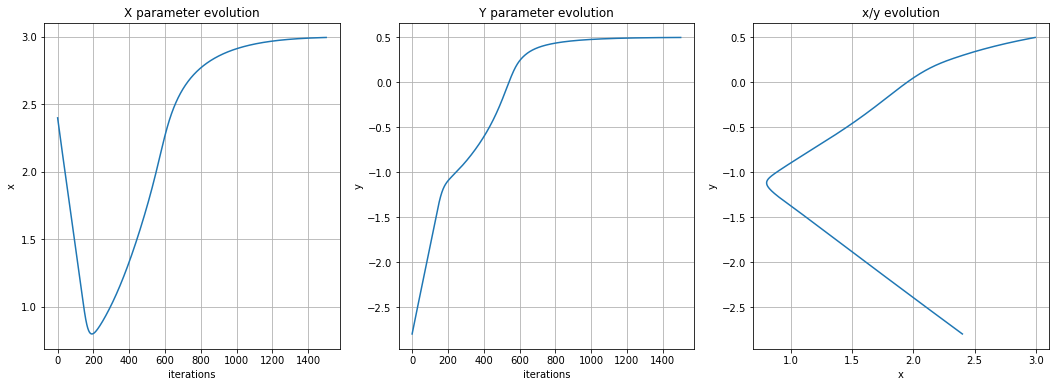

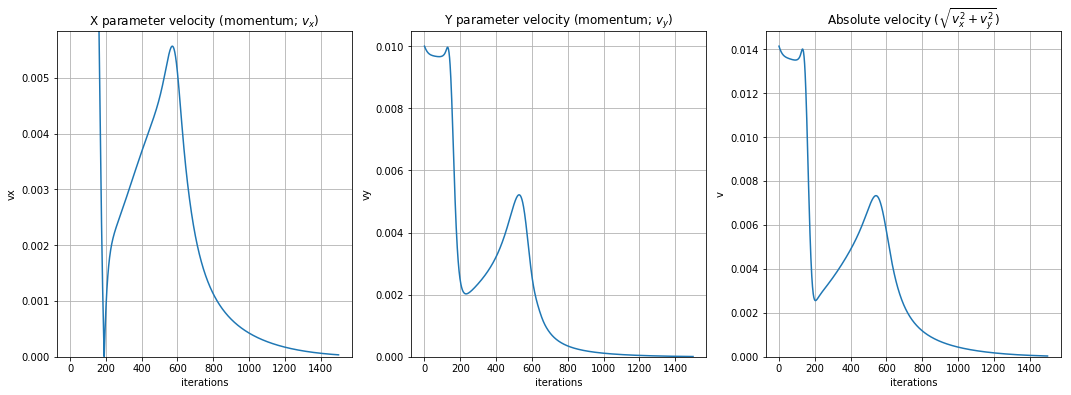

In [45]:
plot_cinematics_charts(xs_adamax, ys_adamax)

## NAdam (Nesterov Adam) 

Nesterov Adam (or simply NAdam) is a modification of the original Adam algorithm that includes Nesterov Momentum (approximated). The differences over the Adam formulation are defined below.

$$ \mathbf{\hat{g}} := \mathbf{g_t} \cdot \frac{1}{1-\mu^t}$$
$$ \overline{\mathbf{m_t}} := (1-\beta_1) \cdot \mathbf{\hat{g_t}} + \beta_1 \cdot \mathbf{\hat{m_t}}$$
$$\mathbf{\theta_t} := \mathbf{\theta_{t-1}} - \alpha \cdot \displaystyle\frac{\overline{\mathbf{m_t}}}{\sqrt{\hat{\mathbf{v_t}}}+ \epsilon}$$

The authors claim that "momentum is most effective with a warming schedule", so $\beta_1$ van also be parametrized by $t$ if desired. For the sake of simplicity, we avoided this detail in this implementation. 

This modified version of Adam works very similarly as original Adam, though in some cases it can be more beneficial.

In [46]:
class NAdam(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta_1=0.9, beta_2=0.999, x=None, y=None):
        super().__init__(cost_f, lr, x, y, beta_1=beta_1, beta_2=beta_2)
        self.m_x, self.m_y, self.v_x, self.v_y, self.t  = 0, 0, 0, 0, 0
        
    def step(self, lr = None):
        self.t += 1
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        dx_hat = dx/(1-self.beta_1**self.t)
        dy_hat = dy/(1-self.beta_1**self.t)
        
        self.m_x = self.beta_1*self.m_x + (1-self.beta_1)*dx
        self.m_y = self.beta_1*self.m_y + (1-self.beta_1)*dy
        self.v_x = self.beta_2*self.v_x + (1-self.beta_2)*(dx**2)
        self.v_y = self.beta_2*self.v_y + (1-self.beta_2)*(dy**2)
        
        m_x_hat = self.m_x/(1-self.beta_1**self.t)
        m_y_hat = self.m_y/(1-self.beta_1**self.t)
        v_x_hat = self.v_x/(1-self.beta_2**self.t)
        v_y_hat = self.v_y/(1-self.beta_2**self.t)
        
        m_x_dash = (1-self.beta_1)*dx_hat + self.beta_1*m_x_hat
        m_y_dash = (1-self.beta_1)*dy_hat + self.beta_1*m_y_hat
        
        self.x = self.x - (lr*m_x_dash)/(np.sqrt(v_x_hat)+epsilon)
        self.y = self.y - (lr*m_y_dash)/(np.sqrt(v_y_hat)+epsilon)
        return [self.x, self.y]
        

#### Application over the objective function

In [47]:
opt = NAdam(cost_f=cost_f, lr=learning_rate)

In [48]:
errors_nadam, distance_nadam,\
xs_nadam, ys_nadam = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

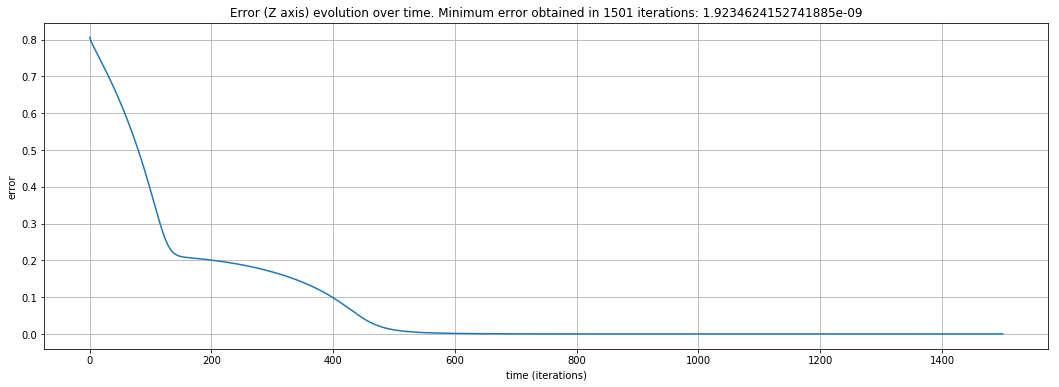

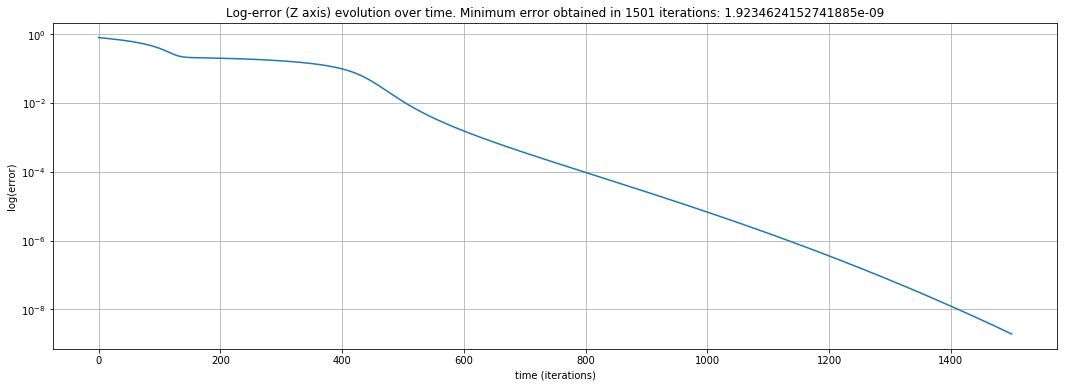

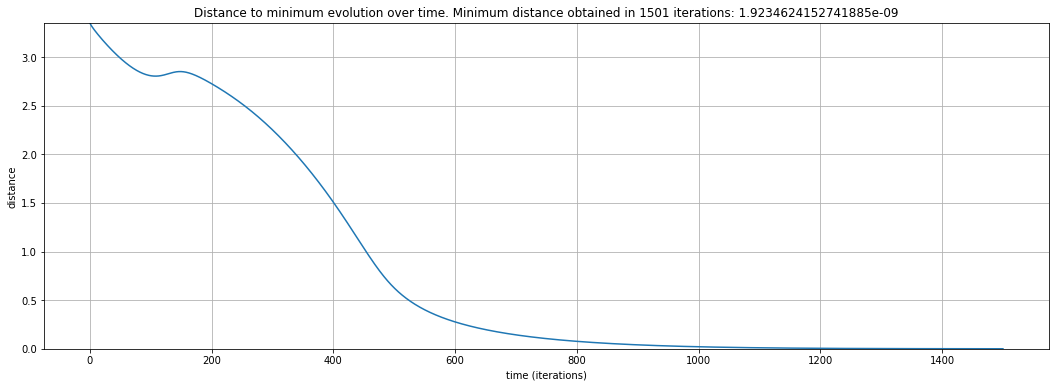

In [49]:
plot_evolution_charts(cost_f, errors_nadam, distance_nadam, xs_nadam, ys_nadam)

#### Cinematics

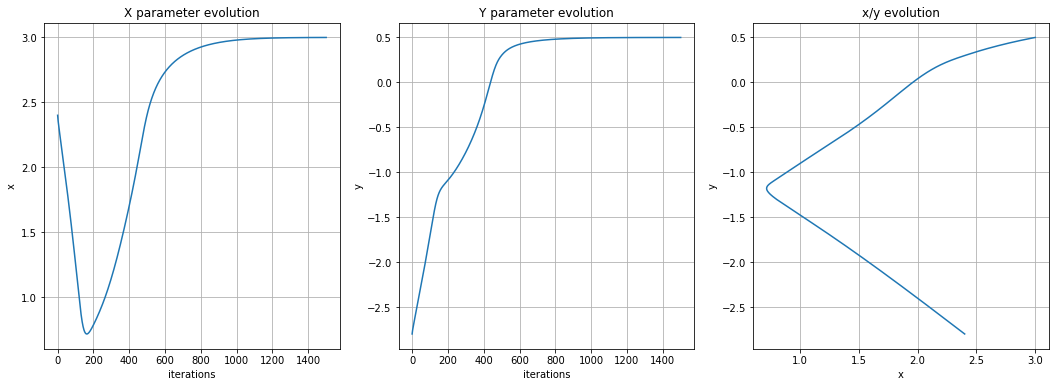

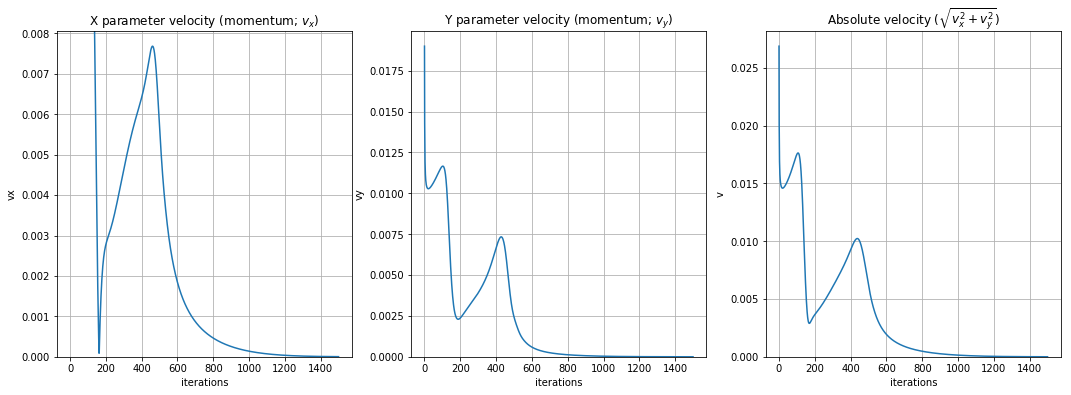

In [50]:
plot_cinematics_charts(xs_nadam, ys_nadam)

## Global comparison

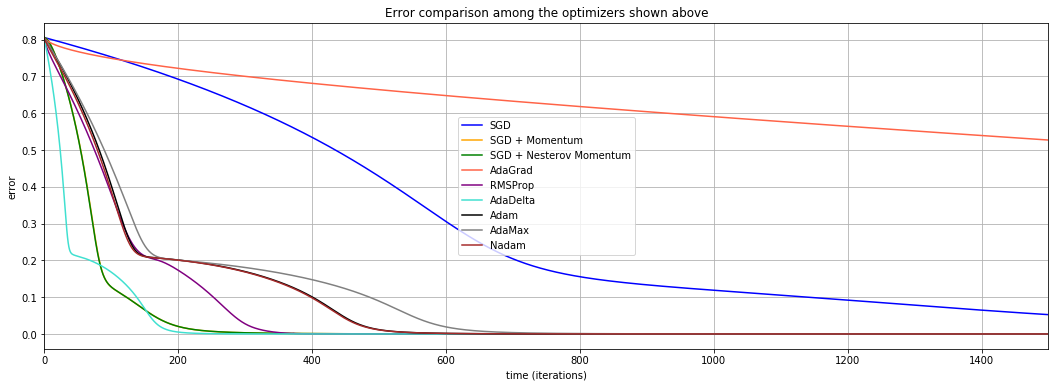

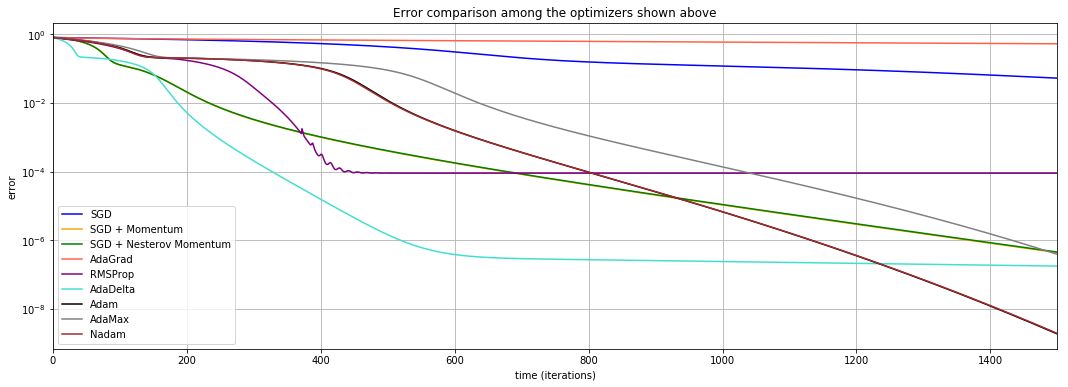

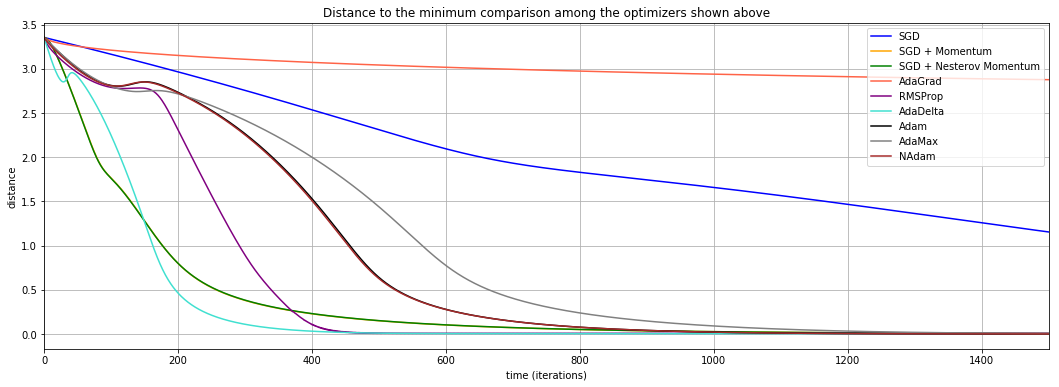

In [51]:
plt.figure(figsize=[18,6])
plt.plot(errors_sgd, color="b")
plt.plot(errors_momentum, color="orange")
plt.plot(errors_nesterov, color="green")
plt.plot(errors_adagrad, color="tomato")
plt.plot(errors_rmsprop, color="purple")
plt.plot(errors_adadelta, color="turquoise")
plt.plot(errors_adam, color="k")
plt.plot(errors_adamax, color="grey")
plt.plot(errors_nadam, color="brown")
plt.title("Error comparison among the optimizers shown above")
plt.ylabel("error")
plt.xlabel("time (iterations)")
plt.legend(labels=["SGD", "SGD + Momentum", "SGD + Nesterov Momentum", "AdaGrad", "RMSProp", "AdaDelta", "Adam", "AdaMax", "Nadam"])
plt.xlim([0,iterations])
plt.grid()
plt.show()

plt.figure(figsize=[18,6])
plt.semilogy(errors_sgd, color="b")
plt.semilogy(errors_momentum, color="orange")
plt.semilogy(errors_nesterov, color="green")
plt.semilogy(errors_adagrad, color="tomato")
plt.semilogy(errors_rmsprop, color="purple")
plt.semilogy(errors_adadelta, color="turquoise")
plt.semilogy(errors_adam, color="k")
plt.semilogy(errors_adamax, color="grey")
plt.semilogy(errors_nadam, color="brown")
plt.title("Error comparison among the optimizers shown above")
plt.ylabel("error")
plt.xlabel("time (iterations)")
plt.legend(labels=["SGD", "SGD + Momentum", "SGD + Nesterov Momentum", "AdaGrad", "RMSProp", "AdaDelta", "Adam", "AdaMax", "Nadam"])
plt.xlim([0,iterations])
plt.grid()
plt.show()

plt.figure(figsize=[18,6])
plt.plot(distance_sgd, color="b")
plt.plot(distance_momentum, color="orange")
plt.plot(distance_nesterov, color="green")
plt.plot(distance_adagrad, color="tomato")
plt.plot(distance_rmsprop, color="purple")
plt.plot(distance_adadelta, color="turquoise")
plt.plot(distance_adam, color="k")
plt.plot(distance_adamax, color="grey")
plt.plot(distance_nadam, color="brown")
plt.title("Distance to the minimum comparison among the optimizers shown above")
plt.ylabel("distance")
plt.xlabel("time (iterations)")
plt.legend(labels=["SGD", "SGD + Momentum", "SGD + Nesterov Momentum", "AdaGrad", "RMSProp", "AdaDelta", "Adam","AdaMax", "NAdam"])
plt.xlim([0,iterations])
plt.grid()
plt.show()

In [52]:
trajectories_dict={"SGD": (xs_sgd, ys_sgd, "b"), 
                    "SGD + Momentum": (xs_momentum, ys_momentum, "orange"), 
                    "SGD + Nesterov": (xs_nesterov, ys_nesterov, "green"), 
                    "AdaGrad": (xs_adagrad, ys_adagrad, "tomato"), 
                    "RMSprop": (xs_rmsprop, ys_rmsprop, "purple"), 
                    "AdaDelta": (xs_adadelta, ys_adadelta, "turquoise"), 
                    "Adam": (xs_adam, ys_adam, "k"),
                    "AdaMax": (xs_adamax, ys_adamax, "grey"),
                    "NAdam": (xs_nadam, ys_nadam, "brown")}

MovieWriter imagemagick unavailable.


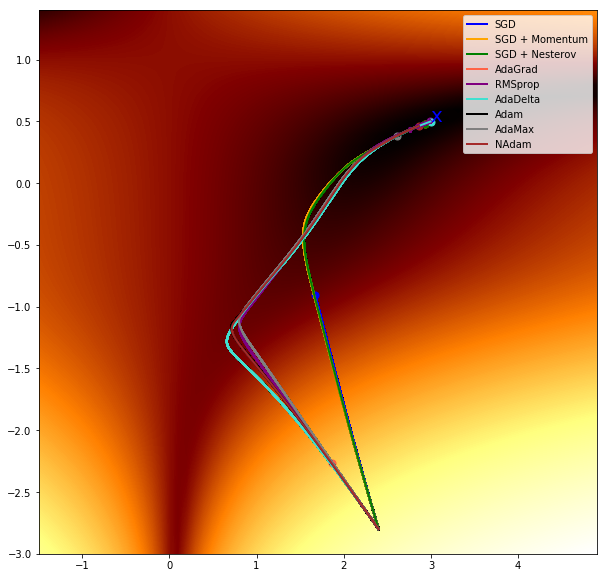

In [53]:
plot_trajectories(trajectories_dict, cost_f, figsize=[10,10], filepath="./img/trajectories.gif", frames=700)

## Conclusions

![trajectories](./img/trajectories_improved.gif)

The original gradient descent algorithm should not be the first choice when training a neural network. Although it is very stable and is difficult to make it diverge, its convergence is very slow.

Other algorithms like **AdaDelta**, **RMSProp** or **Adam** can be more convenient in the majority of the cases, due to their adjustment of the learning rate for each dimension independently. **AdaGrad** represents a very good theoretical idea but their annealing learning rate issue makes it unusable in the majority of the situations. Moment based optimizers must be taken with care, because they can suffer from oscillations which lead to potential performance decreasement.

The most common modifications of the **ADAM** algorithm (**AdaMax** and **NAdam**) have been implemented, though they do not show any substantial improvement over the original algorithm in this objective function

## Disclaimer

The comparison shown in the previous section is not fair and it has been done with the intention of understanding the general behavior of the optimization algorithms. You should not extrapolate conclusions to the neural network optimization problem; they lay in monster-dimensional spaces (in the order of several hundreds of milions) in which the conclusions from this study may not apply. In addition to this, we are using a kind of ceteris paribus approach in the sense that we only change the optimizer algorithm, keeping all the parameters by default. It is not fair because, for example there are some algorithms which are more suited to work with higher learning rates (as it is the case of AdaGrad, for example) and others which are much more sensible to increases of this parameter (SGD with momentum for example).